In [1]:

import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
# -----------------------------------------------------------------------------
# Set random seed & device
# -----------------------------------------------------------------------------
import csv
import time
from datetime import datetime
import os
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

import matplotlib.animation as animation
from IPython.display import HTML


Using cpu


In [28]:
# -----------------------------------------------------------------------------
# Problem constants & helper functions
# -----------------------------------------------------------------------------


# Network architecture: input (x,t) -> 64‑64‑64 hidden units -> output u
layers = [2,128, 128,128,128,128, 1]


class PINN(nn.Module):
    """Simple fully‑connected network with tanh activations."""

    def __init__(self, layers):
        super().__init__()
        blocks = []
        for l_in, l_out in zip(layers[:-2], layers[1:-1]):
            blocks.append(nn.Linear(l_in, l_out))
            blocks.append(nn.Tanh())
        blocks.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*blocks)

        # Xavier (Glorot) initialisation for faster convergence
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        """x, t: tensors of shape (N,1)"""
        input_pair = torch.cat([x, t], dim=1)
        return self.model(input_pair)


def pde_residual(model: nn.Module, x: torch.Tensor, t: torch.Tensor):
    """Compute residual f(x,t) = ∂u/∂t + a ∂u/∂x."""
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)

    # ∂u/∂t
    u_t = autograd.grad(u, t,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]
    # ∂u/∂x
    u_x = autograd.grad(u, x,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]

    return u_t + a * u_x  # residual should be ≈ 0

In [7]:
# Define network architecture variables
num_layers = 7  # number of hidden layers
num_neurons = 128  # neurons per hidden layer



class PINN(nn.Module):
    """Fully‑connected network with cosine activations and variable architecture."""
    def __init__(self, num_layers, num_neurons, input_dim=2, output_dim=1):
        super().__init__()
        blocks = []
        # Input layer
        blocks.append(nn.Linear(input_dim, num_neurons))
        blocks.append(nn.Tanh())
        # Hidden layers
        for _ in range(num_layers - 1):
            blocks.append(nn.Linear(num_neurons, num_neurons))
            blocks.append(nn.Tanh())
        # Output layer
        blocks.append(nn.Linear(num_neurons, output_dim))
        self.model = nn.Sequential(*blocks)

        # Xavier (Glorot) initialisation for faster convergence
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        """x, t: tensors of shape (N,1)"""
        input_pair = torch.cat([x, t], dim=1)
        return self.model(input_pair)



def pde_residual(model: nn.Module, x: torch.Tensor, t: torch.Tensor):
    """Compute residual f(x,t) = ∂u/∂t + a ∂u/∂x."""
    x.requires_grad_(True)
    t.requires_grad_(True)

    u = model(x, t)

    # ∂u/∂t
    u_t = autograd.grad(u, t,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]
    # ∂u/∂x
    u_x = autograd.grad(u, x,
                        grad_outputs=torch.ones_like(u),
                        create_graph=True)[0]

    return u_t + a * u_x  # residual should be ≈ 0

In [8]:

def get_density(t):
    """
    Returns the density (as a PyTorch tensor) based on time t (in seconds).
    Supports scalar or batch tensor input.
    
    Parameters:
        t (torch.Tensor): Time(s) in seconds.
        
    Returns:
        torch.Tensor: Density (kg/m³), same shape as t.
    """
    t = torch.as_tensor(t, dtype=torch.float32)
    cycle_position = torch.floor(t / 300).to(torch.int32)
    
    # Even cycles → water (1000), Odd cycles → phosphate (1800)
    density = torch.where(cycle_position % 2 == 0,
                          torch.tensor(1),
                          torch.tensor(1.6))
    return density



def get_viscosity(t):
    """
    Returns the density (as a PyTorch tensor) based on time t (in seconds).
    Supports scalar or batch tensor input.
    
    Parameters:
        t (torch.Tensor): Time(s) in seconds.
        
    Returns:
        torch.Tensor: Density (kg/m³), same shape as t.
    """
    t = torch.as_tensor(t, dtype=torch.float32)
    cycle_position = torch.floor(t / 360).to(torch.int32)
    # Even cycles → water (1000), Odd cycles → phosphate (1800)
    # Mu = 1.6 for water, Mu = 1 for phosphate

    Mu = torch.where(cycle_position % 2 == 0,
                          torch.tensor(1),
                          torch.tensor(0.01))
    return Mu
    # return Mu


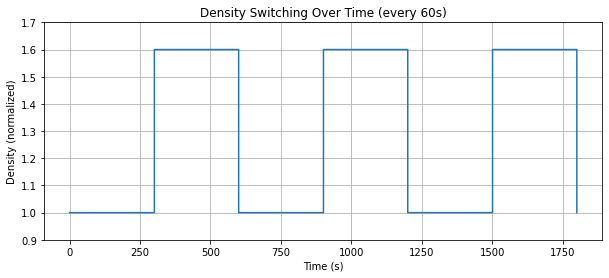

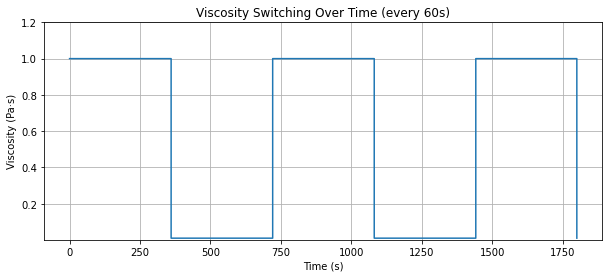

In [9]:
# Generate time values from 0 to 600 seconds
t_values = torch.linspace(0, 1800, steps=1000)
density_values = get_density(t_values)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_values, density_values, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Density (normalized)")
plt.title("Density Switching Over Time (every 60s)")
plt.grid(True)
plt.ylim(0.9, 1.7)
plt.show()

# Generate time values from 0 to 600 seconds
t_values = torch.linspace(0, 1800, steps=1000)
vi_values = get_viscosity(t_values)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_values, vi_values, drawstyle='steps-post')
plt.xlabel("Time (s)")
plt.ylabel("Viscosity (Pa·s)")
plt.title("Viscosity Switching Over Time (every 60s)")
plt.grid(True)
plt.ylim(1e-3, 1.2)
plt.show()

In [16]:
# -----------------------------------------------------------------------------
# Training data (collocation + IC + BC)
# -----------------------------------------------------------------------------
a = 4/1.8 # advection speed


T_final = 1800   # seconds
# Pipe length (m)
Pipe_length = 2000

N_f = 5000 # interior collocation points
N_i = 2000     # initial‑condition points
N_b = 5000    # boundary‑condition points

Pipe_diameter = 0.85  # m

# Interior points: (x,t) uniformly sampled in [0, L] x [0, T]
x_f = Pipe_length*torch.rand( N_f, 1, device=device, dtype=torch.float32)
t_f = T_final*torch.rand(N_f,1, device=device)     # <--- scaled by T_final

# Initial condition: t = 0
x_i = Pipe_length*torch.rand(N_i, 1, device=device)
t_i = torch.zeros_like(x_i)
Rho_i = 1
Mu_i = 0.01
P_i = 1
# Boundary condition: x = 0
x_b = torch.zeros(N_b, 1, device=device)
epsilon = 1e-8  # Small value to avoid 0
t_b = T_final * ( torch.rand(N_b, 1, device=device))
Rho_b = get_density(t_b)
Mu_b = get_viscosity(t_b)
x_b_out = torch.full((N_b, 1), Pipe_length, device=device)
P_b = 1

In [17]:
# -----------------------------------------------------------------------------
# Model & optimisers
# -----------------------------------------------------------------------------
Rho = PINN(num_layers, num_neurons).to(device)
opt_adam = torch.optim.Adam(Rho.parameters(), lr=1e-3)
opt_lbfgs = torch.optim.LBFGS(Rho.parameters(),
                              lr=1.0,
                              max_iter=1000,
                              tolerance_grad=1e-9,
                              tolerance_change=1e-9,
                              history_size=100,
                              line_search_fn="strong_wolfe")


In [18]:

loss_weights = [1, 1, 1]  # Weights used in loss calculation

def loss_components():
    """Returns individual MSE losses: residual, IC, BC."""
    f = pde_residual(Rho, x_f, t_f)
    rho_pred_i = Rho(x_i, t_i)
    rho_pred_b = Rho(x_b, t_b)
    loss_f = torch.mean(f ** 2)
    loss_i = torch.mean((rho_pred_i - Rho_i) ** 2)
    loss_b = torch.mean((rho_pred_b - Rho_b) ** 2)

    return loss_weights[0]*loss_f, loss_weights[1]*loss_i, loss_weights[2]*loss_b

In [ ]:
# -----------------------------------------------------------------------------
# Stage 1 – Adam optimisation
# -----------------------------------------------------------------------------

epochs = 8000
start_time = time.time()

for ep in range(epochs):
    # Adam step
    # Compute loss and gradients
    # and update weights
    # with Adam
    # (requires closure function)
    opt_adam.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    opt_adam.step()

    if ep % 500 == 0:
        print(f"Adam  {ep:4d}: total={loss.item():.3e}"
              f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")

# -----------------------------------------------------------------------------
# Stage 2 – L‑BFGS fine‑tuning
# -----------------------------------------------------------------------------

print("Starting L‑BFGS …")

def closure():
    opt_lbfgs.zero_grad()
    lf, li, lb = loss_components()
    loss = lf + li + lb
    loss.backward()
    return loss

opt_lbfgs.step(closure)
print("L‑BFGS complete.")

training_time = time.time() - start_time

print(f"Training time: {training_time:.2f} seconds")
print(f"Final loss: {loss.item():.3e}"
      f"(res={lf.item():.1e}, IC={li.item():.1e}, BC={lb.item():.1e})")


Adam     0: total=1.191e+00(res=5.3e-05, IC=2.5e-01, BC=9.5e-01)
Adam   500: total=8.049e-02(res=6.8e-06, IC=6.0e-04, BC=8.0e-02)


In [153]:


def save_training_results(model, losses, weights, training_time):
    """Append training results to CSV file"""
    
    filename = "/home/marwan.housni/lustre/manapy-um6p-st-msda-1wabcjwe938/users/marwan.housni/internship/PINNs/rho_training_history.csv"
    is_new_file = not os.path.exists(filename)
    
    # Collect training parameters
    results = {
        "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "Architecture": f"{num_layers}-{num_neurons}",
        "Activation": "Tanh",
        "N_interior": N_f,
        "N_initial": N_i,
        "N_boundary": N_b,
        "Pipe_length": Pipe_length,
        "Pipe_diameter": Pipe_diameter,
        "T_final": T_final,
        "Training_time_seconds": training_time,
        "Loss_residual": losses[0].item(),
        "Loss_initial": losses[1].item(),
        "Loss_boundary": losses[2].item(),
        "Weight_residual": weights[0],
        "Weight_initial": weights[1],
        "Weight_boundary": weights[2],
        "Total_loss": sum(l.item()*w for l,w in zip(losses, weights)),
        "device ": device,
    }
    
    # Write to CSV
    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=results.keys())
        if is_new_file:
            writer.writeheader()
        writer.writerow(results)
    
    print(f"Training results appended to {filename}")



save_training_results(Rho, loss_components(), loss_weights, training_time)

Training results appended to /home/marwan.housni/lustre/manapy-um6p-st-msda-1wabcjwe938/users/marwan.housni/internship/PINNs/rho_training_history.csv


In [ ]:
x_line = torch.linspace(0, Pipe_length, 5000, device=device).view(-1, 1)
snapshot_times = torch.arange(0, 1801, 100, device=device)

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("Position (m)", fontsize=12)
ax.set_ylabel("Density ρ(x,t)", fontsize=12)
ax.set_title("Density Evolution Over Time", fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)

# Create animation elements
line, = ax.plot([], [], 'b-', linewidth=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.8))

# Set axis limits
ax.set_xlim(0, Pipe_length)
ax.set_ylim(0.8, 1.7)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    t_val = snapshot_times[i]
    t_line = t_val.expand_as(x_line)
    
    with torch.no_grad():
        u_pred_line = Rho(x_line, t_line).cpu().numpy().flatten()
    
    line.set_data(x_line.cpu().numpy().flatten(), u_pred_line)
    time_text.set_text(f'Time: {t_val.item():.0f} s')

    return line, time_text

# Create animation
ani = animation.FuncAnimation(
    fig, animate, frames=len(snapshot_times),
    init_func=init, blit=True, interval=200
)

plt.close(fig)
HTML(ani.to_jshtml())

In [ ]:
# -----------------------------------------------------------------------------
# Evaluation & Visualisation – separate line plots at each snapshot
# -----------------------------------------------------------------------------

import matplotlib.cm as cm

# Spatial grid for line plots
x_line = torch.linspace(0, Pipe_length, 5000, device=device).view(-1, 1)

# Snapshot times
snapshot_times = torch.tensor([10,0,100,360,500,720,900,1080,1200,1300,1400,1800,2000], device=device)
#snapshot_times = torch.tensor([1080,1200,1300,1400,1800,1800,1900,2000,2200,2400,2600,2800,3000,3200,3400,3600], device=device)

colors = cm.viridis(torch.linspace(0.001, 1, len(snapshot_times)))

for idx, (t_val, color) in enumerate(zip(snapshot_times, colors)):
    t_line = t_val.expand_as(x_line)
    with torch.no_grad():
        u_pred_line = Rho(x_line, t_line).cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.plot(x_line.cpu().numpy().flatten(), u_pred_line, color=color, linewidth=2)
    plt.xlabel("x (m)", fontsize=12)
    plt.ylabel("Rho(x, t)", fontsize=12)
    plt.title(f"PINN Solution at t = {t_val.item():.0f} s", fontsize=14)
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot Rho at the outlet (x = Pipe_length) as a function of time
t_outlet = torch.linspace(0, 7* T_final, 500, device=device).view(-1, 1)
x_outlet = torch.full_like(t_outlet, Pipe_length)

with torch.no_grad():
    rho_outlet = Rho(x_outlet, t_outlet).cpu().numpy().flatten()

plt.figure(figsize=(8, 4))
plt.plot(t_outlet.cpu().numpy().flatten(), rho_outlet, color='crimson', linewidth=2)
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Rho at Outlet (x = L)", fontsize=12)
plt.title("Outlet Rho vs Time", fontsize=14)
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()